In [141]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style="darkgrid")

plt.rcParams['figure.figsize'] = [15, 6]
plt.rc('font', size=14)          # controls default text sizes
plt.rc('figure', titlesize=15)  # fontsize of the figure title

In [38]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../src/')

from ensembles import RandomForestMSE, GradientBoostingMSE, mean_squared_error, root_mean_squared_error

In [3]:
def savefig(name):
    plt.savefig(f"figures/{name}.pdf", bbox_inches='tight')

In [61]:
data = pd.read_csv("kc_house_data.csv")
print(data.shape)
data.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## EXP1

In [62]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [63]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data.drop(columns=["date"], inplace=True)
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [64]:
data["id"].value_counts()

id
795000620     3
8651510380    2
2568300045    2
9353300600    2
4139480200    2
             ..
2767603649    1
1446403617    1
5602000275    1
1786200010    1
1523300157    1
Name: count, Length: 21436, dtype: int64

In [65]:
data[data["id"] == 795000620]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
17602,795000620,115000.0,3,1.0,1080,6250,1.0,0,0,2,...,1950,0,98168,47.5045,-122.33,1070,6250,2014,9,24
17603,795000620,124000.0,3,1.0,1080,6250,1.0,0,0,2,...,1950,0,98168,47.5045,-122.33,1070,6250,2014,12,15
17604,795000620,157000.0,3,1.0,1080,6250,1.0,0,0,2,...,1950,0,98168,47.5045,-122.33,1070,6250,2015,3,11


In [66]:
data.drop(columns=["id"], inplace=True)

In [67]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [68]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["price"]).to_numpy()
y = data["price"].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(15129, 21)

## EXP2: random forest

### Зависимость RMSE и времени работы random forest от кол-ва деревьев

In [86]:
N_ESTIMATORS = 300
MAX_DEPTH = 10

rforest = RandomForestMSE(n_estimators=N_ESTIMATORS, max_depth=None)
rforest.fit(X_train, y_train, X_test, y_test)

rforest_limit_depth = RandomForestMSE(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
rforest_limit_depth.fit(X_train, y_train, X_test, y_test)

errors_history = rforest.ensemble_errors_history
errors_history_limit_depth = rforest_limit_depth.ensemble_errors_history

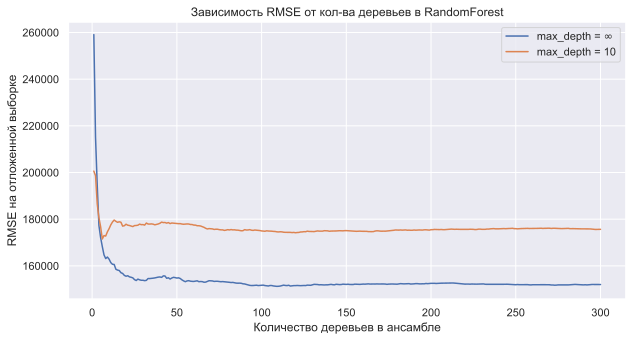

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, N_ESTIMATORS + 1), errors_history, label="max_depth = $\\infty$")
plt.plot(np.arange(1, N_ESTIMATORS + 1), errors_history_limit_depth, label=f"max_depth = {MAX_DEPTH}")
plt.legend()
plt.title("Зависимость RMSE от кол-ва деревьев в RandomForest")
plt.xlabel("Количество деревьев в ансамбле")
plt.ylabel("RMSE на отложенной выборке")
savefig("2_n_estimators_rmse")
plt.show()

**Выводы:**
1. Время обучения и предсказания, очеведно, линейно зависят от числа деревьев в ансамбле.
2. Нет переобучения с увеличением числа деревьев
3. Ошибка выходит на асимптоту

Фиксируем n_estimators = 100

### Зависимость RMSE и времени работы random forest от размерности подвыборки признаков для одного дерева

**Написать** про выбор случайного подмножества признаков в каждой вершине.

In [137]:
feature_subsample_size_arr = np.arange(1, X_train.shape[1] + 1)

rmse_arr_sub = np.zeros_like(feature_subsample_size_arr, dtype="float64")
learning_time_sub = np.zeros_like(rmse_arr_sub)
pred_time_sub = np.zeros_like(rmse_arr_sub)
for i, feature_subsample_size in enumerate(tqdm(feature_subsample_size_arr)):
    rforest = RandomForestMSE(feature_subsample_size=feature_subsample_size)
    t = time()
    rforest.fit(X_train, y_train)
    learning_time_sub[i] = time() - t
    t = time()
    pred = rforest.predict(X_test)
    pred_time_sub[i] = time() - t
    rmse_arr_sub[i] = root_mean_squared_error(y_test, pred)

100%|██████████| 21/21 [02:57<00:00,  8.43s/it]


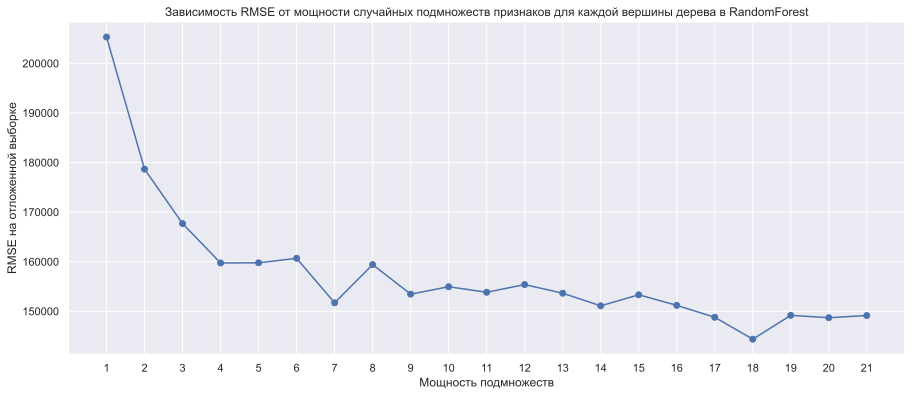

In [143]:
plt.plot(feature_subsample_size_arr, rmse_arr_sub, marker="o")
plt.title("Зависимость RMSE от мощности случайных подмножеств признаков для каждой вершины дерева в RandomForest")
plt.xlabel("Мощность подмножеств")
plt.ylabel("RMSE на отложенной выборке")
plt.xticks(feature_subsample_size_arr)
savefig("2_sub_rmse")
plt.show()

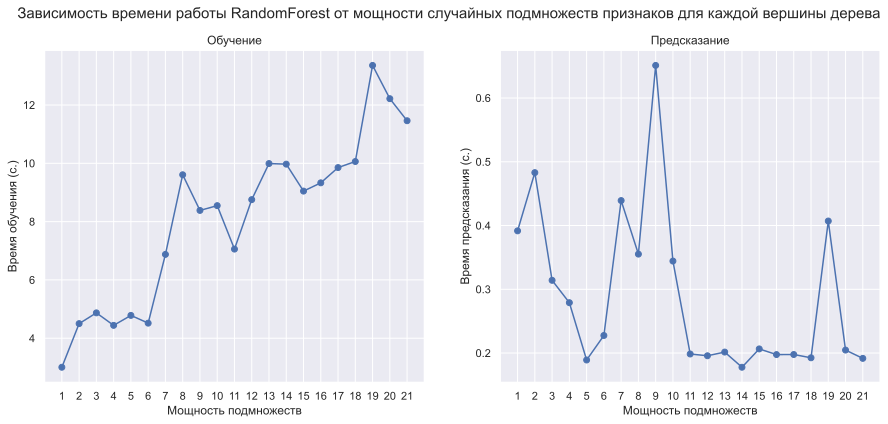

In [149]:
plt.suptitle("Зависимость времени работы RandomForest от мощности случайных подмножеств признаков для каждой вершины дерева")

plt.subplot(1, 2, 1)
plt.plot(feature_subsample_size_arr, learning_time_sub, marker="o")
plt.title("Обучение")
plt.xlabel("Мощность подмножеств")
plt.ylabel("Время обучения (с.)")
plt.xticks(feature_subsample_size_arr)

plt.subplot(1, 2, 2)
plt.plot(feature_subsample_size_arr, pred_time_sub, marker="o")
plt.title("Предсказание")
plt.xlabel("Мощность подмножеств")
plt.ylabel("Время предсказания (с.)")
plt.xticks(feature_subsample_size_arr)

savefig("2_sub_time")
plt.show()

**Выводы:**
1. Мощность больше - меньше RMSE (но min при 18)
2. Мощность больше - больше время обучения ( $\approx$ линейсная зависимость)
3. Время предсказания не зависит от мощности

фиксируем feature_subsample_size = 18

In [150]:
rforest_parms = {
    "n_estimators": 100,
    "feature_subsample_size": 18
}

### Зависимость RMSE и времени работы random forest от max_depth

In [176]:
max_depth_list = [1, 5, 10, 20, 50, 100, 150, None]


rmse_arr_depth = np.zeros(len(max_depth_list))
learning_time_depth = np.zeros_like(rmse_arr_depth)
pred_time_depth = np.zeros_like(rmse_arr_depth)
for i, max_depth in enumerate(tqdm(max_depth_list)):
    rforest = RandomForestMSE(**rforest_parms, max_depth=max_depth)
    t = time()
    rforest.fit(X_train, y_train)
    learning_time_depth[i] = time() - t
    t = time()
    pred = rforest.predict(X_test)
    pred_time_depth[i] = time() - t
    rmse_arr_depth[i] = root_mean_squared_error(y_test, pred)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:56<00:00,  7.12s/it]


c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

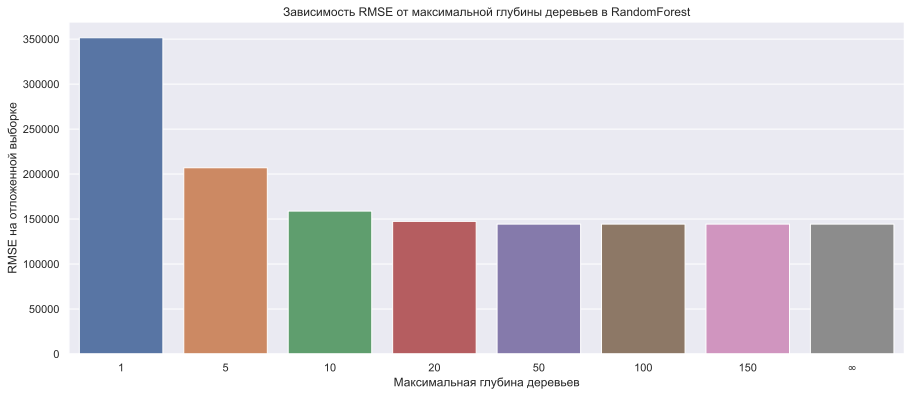

In [185]:
max_depth_list_str = list(map(str, max_depth_list[:-1])) + ["$\\infty$"]

#plt.figure(figsize=(10, 6))
sns.barplot(x=max_depth_list_str, y=rmse_arr_depth)
plt.title("Зависимость RMSE от максимальной глубины деревьев в RandomForest")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("RMSE на отложенной выборке")
savefig("2_depth_rmse")
plt.show()

c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

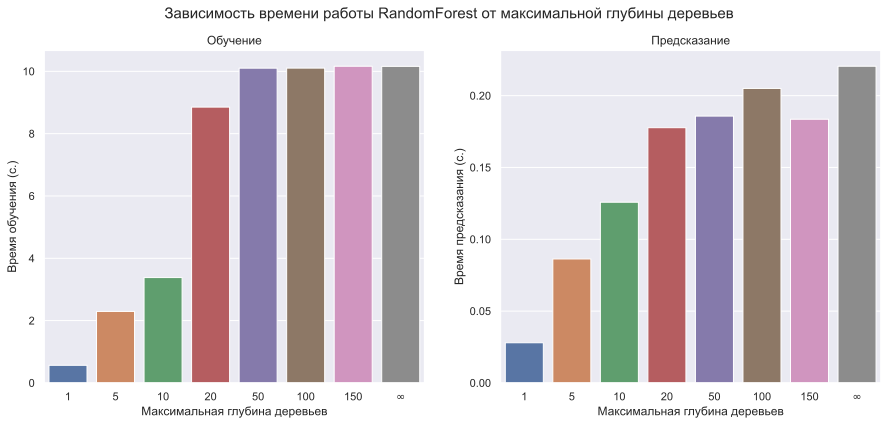

In [178]:
plt.suptitle("Зависимость времени работы RandomForest от максимальной глубины деревьев")

plt.subplot(1, 2, 1)
sns.barplot(x=max_depth_list_str, y=learning_time_depth)
plt.title("Обучение")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("Время обучения (с.)")

plt.subplot(1, 2, 2)
sns.barplot(x=max_depth_list_str, y=pred_time_depth)
plt.title("Предсказание")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("Время предсказания (с.)")

savefig("2_depth_time")
plt.show()

Выводы:
1. С увеличением максимальной шлубины деревьев RMSE уменьшается, время работы увеличивается.
2. При максимальной глубине $\geqslant 50$ разница в RMSE и времени работы не заметна.

фиксируем max_depth = $\infty$

In [180]:
rforest_parms["max_depth"] = None

In [182]:
rforest_best = RandomForestMSE(**rforest_parms)
rforest_best.fit(X_train, y_train)
pred = rforest_best.predict(X_test)
RMSE_rforest = root_mean_squared_error(y_test, pred)
print(f"RMSE для RandomForest с лучшими параметрами: {RMSE_rforest:.2f}")

RMSE для RandomForest с лучшими параметрами: 144373.02


## EXP3: GradientBoosting

### Зависимость RMSE и времени работы GradientBoosting от кол-ва деревьев

In [199]:
N_ESTIMATORS_BOOST = 200
MAX_DEPTH_BOOST = 5

boost = GradientBoostingMSE(n_estimators=N_ESTIMATORS_BOOST, max_depth=None)
boost.fit(X_train, y_train, X_test, y_test)

boost_limit_depth = GradientBoostingMSE(n_estimators=N_ESTIMATORS_BOOST, max_depth=MAX_DEPTH_BOOST)
boost_limit_depth.fit(X_train, y_train, X_test, y_test)

errors_history_boost = boost.ensemble_errors_history
errors_history_limit_depth_boost = boost_limit_depth.ensemble_errors_history

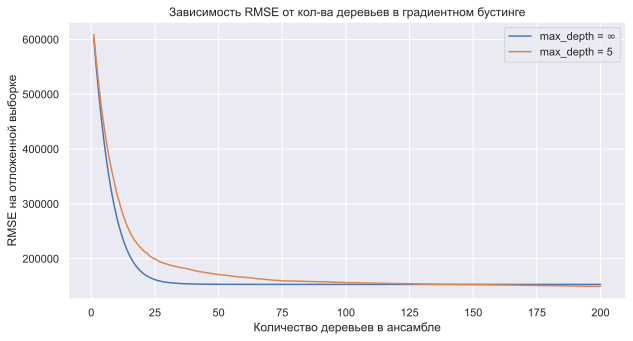

In [200]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, N_ESTIMATORS_BOOST + 1), errors_history_boost, label="max_depth = $\\infty$")
plt.plot(np.arange(1, N_ESTIMATORS_BOOST + 1), errors_history_limit_depth_boost, label=f"max_depth = {MAX_DEPTH_BOOST}")
plt.legend()
plt.title("Зависимость RMSE от кол-ва деревьев в градиентном бустинге")
plt.xlabel("Количество деревьев в ансамбле")
plt.ylabel("RMSE на отложенной выборке")
savefig("3_n_estimators_rmse")
plt.show()

**Выводы:**
1. Аналогично случайному лесу
2. Более плавные кривые

Фиксируем n_estimators = 100

### Зависимость RMSE и времени работы GradientBoosting от размерности подвыборки признаков для одного дерева

**Написать** про выбор случайного подмножества признаков в каждой вершине.

In [207]:
rmse_arr_sub_bst = np.zeros_like(feature_subsample_size_arr, dtype="float64")
learning_time_sub_bst = np.zeros_like(rmse_arr_sub_bst)
pred_time_sub_bst = np.zeros_like(rmse_arr_sub_bst)
for i, feature_subsample_size in enumerate(tqdm(feature_subsample_size_arr)):
    bst = GradientBoostingMSE(feature_subsample_size=feature_subsample_size)
    t = time()
    bst.fit(X_train, y_train)
    learning_time_sub_bst[i] = time() - t
    t = time()
    pred = bst.predict(X_test)
    pred_time_sub_bst[i] = time() - t
    rmse_arr_sub_bst[i] = root_mean_squared_error(y_test, pred)

100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


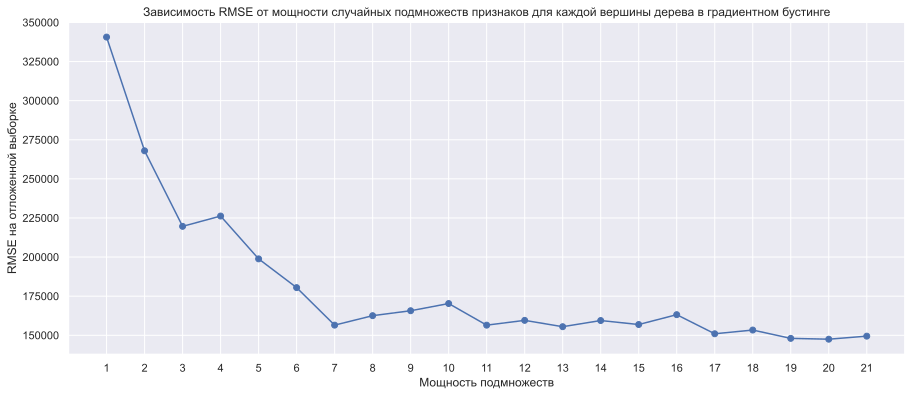

In [208]:
plt.plot(feature_subsample_size_arr, rmse_arr_sub_bst, marker="o")
plt.title("Зависимость RMSE от мощности случайных подмножеств признаков для каждой вершины дерева в градиентном бустинге")
plt.xlabel("Мощность подмножеств")
plt.ylabel("RMSE на отложенной выборке")
plt.xticks(feature_subsample_size_arr)
savefig("3_sub_rmse")
plt.show()

In [203]:
feature_subsample_size_arr[np.argmin(rmse_arr_sub_bst)]

20

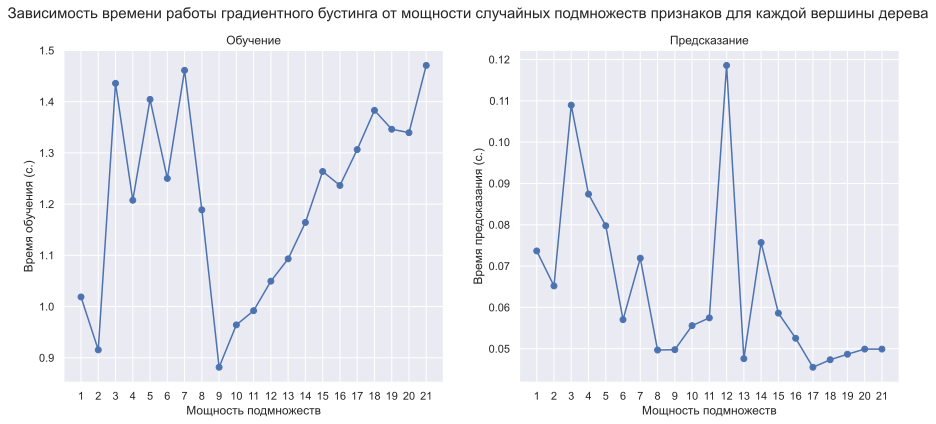

In [209]:
plt.suptitle("Зависимость времени работы градиентного бустинга от мощности случайных подмножеств признаков для каждой вершины дерева")

plt.subplot(1, 2, 1)
plt.plot(feature_subsample_size_arr, learning_time_sub_bst, marker="o")
plt.title("Обучение")
plt.xlabel("Мощность подмножеств")
plt.ylabel("Время обучения (с.)")
plt.xticks(feature_subsample_size_arr)

plt.subplot(1, 2, 2)
plt.plot(feature_subsample_size_arr, pred_time_sub_bst, marker="o")
plt.title("Предсказание")
plt.xlabel("Мощность подмножеств")
plt.ylabel("Время предсказания (с.)")
plt.xticks(feature_subsample_size_arr)

savefig("3_sub_time")
plt.show()

**Выводы:**
1. Мощность больше - меньше RMSE (но min при 20)
2. График времени обучения имеет "резкий провал" при мощности подмножеств = 9 (не известно почему), после чего наблюдается линейная зависимость времени работы от мощности подмножеств (больше мощность - больше время обучения)
3. Время предсказания не зависит от мощности.

фиксируем feature_subsample_size = 20

In [211]:
bst_parms = {
    "n_estimators": 100,
    "feature_subsample_size": 20
}

### Зависимость RMSE и времени работы GradientBoosting от max_depth

In [227]:
max_depth_list_bst = [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50, None]

rmse_arr_depth_bst = np.zeros(len(max_depth_list_bst))
learning_time_depth_bst = np.zeros_like(rmse_arr_depth_bst)
pred_time_depth_bst = np.zeros_like(rmse_arr_depth_bst)
for i, max_depth in enumerate(tqdm(max_depth_list_bst)):
    bst = GradientBoostingMSE(**bst_parms, max_depth=max_depth)
    t = time()
    bst.fit(X_train, y_train)
    learning_time_depth_bst[i] = time() - t
    t = time()
    pred = bst.predict(X_test)
    pred_time_depth_bst[i] = time() - t
    rmse_arr_depth_bst[i] = root_mean_squared_error(y_test, pred)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:59<00:00,  5.00s/it]


c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

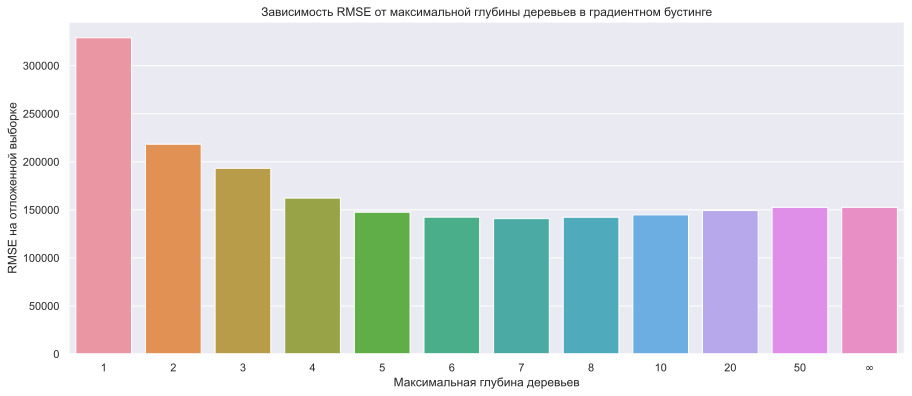

In [228]:
max_depth_list_str_bst = list(map(str, max_depth_list_bst[:-1])) + ["$\\infty$"]

#plt.figure(figsize=(10, 6))
sns.barplot(x=max_depth_list_str_bst, y=rmse_arr_depth_bst)
plt.title("Зависимость RMSE от максимальной глубины деревьев в градиентном бустинге")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("RMSE на отложенной выборке")
savefig("3_depth_rmse")
plt.show()

In [229]:
max_depth_list_bst[np.argmin(rmse_arr_depth_bst)]

7

c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\valer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

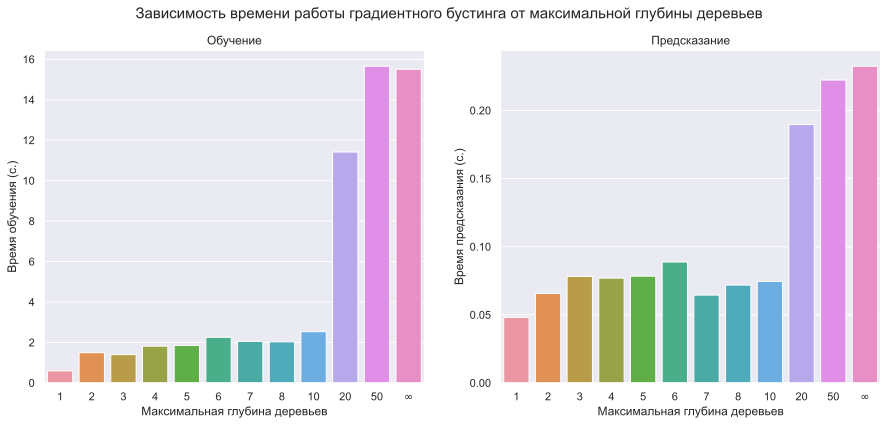

In [230]:
plt.suptitle("Зависимость времени работы градиентного бустинга от максимальной глубины деревьев")

plt.subplot(1, 2, 1)
sns.barplot(x=max_depth_list_str_bst, y=learning_time_depth_bst)
plt.title("Обучение")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("Время обучения (с.)")

plt.subplot(1, 2, 2)
sns.barplot(x=max_depth_list_str_bst, y=pred_time_depth_bst)
plt.title("Предсказание")
plt.xlabel("Максимальная глубина деревьев")
plt.ylabel("Время предсказания (с.)")

savefig("3_depth_time")
plt.show()

Выводы:
1. RMSE как функция, зависящая от максимальной глубины, выпукла вниз и имеет минимум в точке 7.
2. С увеличением максимальной глубины деревьев время работы увеличивается.

фиксируем max_depth = $7$

In [231]:
bst_parms["max_depth"] = 7

### Зависимость RMSE и времени работы GradientBoosting от learning_rate

In [233]:
learing_rate_arr = np.logspace(-4, 1, 20)

rmse_arr_lrate = np.zeros_like(learing_rate_arr)
learning_time_lrate = np.zeros_like(rmse_arr_lrate)
pred_time_lrate = np.zeros_like(rmse_arr_lrate)
for i, lrate in enumerate(tqdm(learing_rate_arr)):
    bst = GradientBoostingMSE(**bst_parms, learning_rate=lrate)
    t = time()
    bst.fit(X_train, y_train)
    learning_time_lrate[i] = time() - t
    t = time()
    pred = bst.predict(X_test)
    pred_time_lrate[i] = time() - t
    rmse_arr_lrate[i] = root_mean_squared_error(y_test, pred)

100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


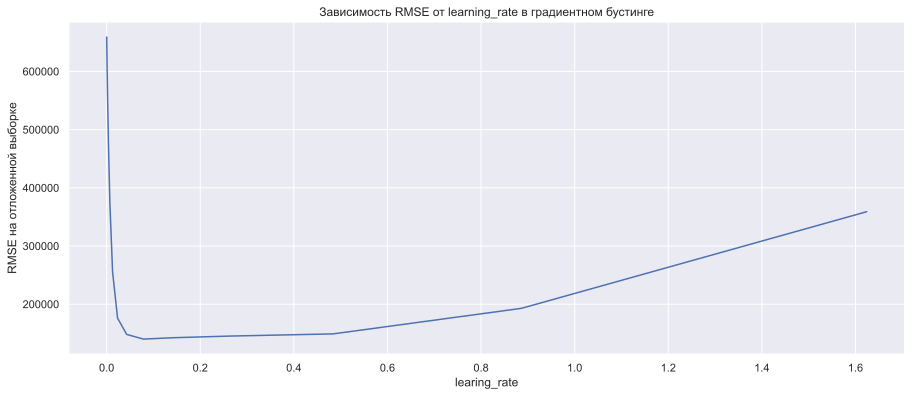

In [245]:
lrate_idx_end = 17
plt.plot(learing_rate_arr[:lrate_idx_end], rmse_arr_lrate[:lrate_idx_end])
plt.title("Зависимость RMSE от learning_rate в градиентном бустинге")
plt.xlabel("learing_rate")
plt.ylabel("RMSE на отложенной выборке")
savefig("3_lrate_rmse")
plt.show()

In [247]:
learing_rate_arr[np.argmin(rmse_arr_lrate)]

0.07847599703514607

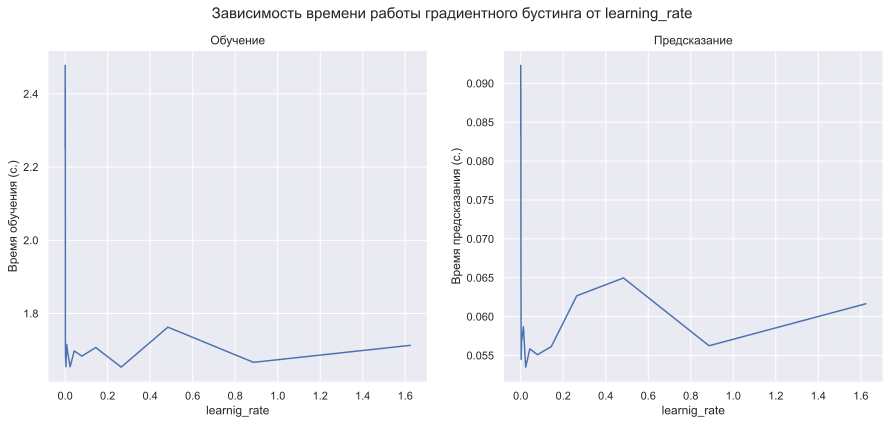

In [251]:
plt.suptitle("Зависимость времени работы градиентного бустинга от learning_rate")

plt.subplot(1, 2, 1)
plt.plot(learing_rate_arr[:lrate_idx_end], learning_time_lrate[:lrate_idx_end])
plt.title("Обучение")
plt.xlabel("learnig_rate")
plt.ylabel("Время обучения (с.)")

plt.subplot(1, 2, 2)
plt.plot(learing_rate_arr[:lrate_idx_end], pred_time_lrate[:lrate_idx_end])
plt.title("Предсказание")
plt.xlabel("learnig_rate")
plt.ylabel("Время предсказания (с.)")

savefig("3_lrate_time")
plt.show()

**Выводы:**
1. RMSE как функция от learning_rate выпукла вниз и имеет минимум где-то в окрестности точки 0.07.
2. При слишком маленьком learning_rate ошибка большая.
3. При learning_rate $> 1$ RMSE резко возрастает.
4. Можно сказать, что время работы алгоритма не зависит от learning_rate.

In [256]:
bst_parms["learning_rate"] = 0.1

In [265]:
bst_best = GradientBoostingMSE(**bst_parms)
bst_best.fit(X_train, y_train)
pred = bst_best.predict(X_test)
RMSE_bst = root_mean_squared_error(y_test, pred)
print(f"RMSE для градиентного бустинга с лучшими параметрами: {RMSE_bst:.2f},")
print(f"что меньше, чем у случайного леса на {RMSE_rforest - RMSE_bst :.2f} ({(RMSE_rforest - RMSE_bst) / RMSE_bst * 100 :.1f} %)")

RMSE для градиентного бустинга с лучшими параметрами: 140848.83,
что меньше, чем у случайного леса на 3524.19 (2.5 %)


Градентный бустинг дал лучшее качество